In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [ ]:
df_e = pd.read_csv('final_encoded_with_distance.csv')

In [ ]:
df_we = pd.read_csv('final_df.csv')

In [ ]:
area_dummy_columns = [col for col in df_e.columns if col.startswith('district_')]

df_e = df_e.drop(columns=area_dummy_columns)

In [ ]:
area_dummy_columns = [col for col in df_e.columns if col.startswith('area_')]

df_e = df_e.drop(columns=area_dummy_columns)

In [ ]:
df_e.columns

Index(['price', 'metro_time', 'info_total_area', 'floor_ratio', 'firt_floor',
       'last_floor', 'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4',
       'rooms_студия', 'rent_jkh_включена (без счётчиков)',
       'rent_jkh_включена (счётчики включены)', 'rent_prepayment_1 месяц',
       'rent_prepayment_2 месяца', 'rent_prepayment_3 месяца',
       'rent_term_несколько месяцев', 'rent_term_от года',
       'rent_living_conditions_можно с детьми',
       'rent_living_conditions_можно с детьми и животными',
       'rent_living_conditions_можно с животными',
       'rent_living_conditions_ни с детьми, ни с животными',
       'year_built_interval_1890-1917', 'year_built_interval_1917-1945',
       'year_built_interval_1945-1970', 'year_built_interval_1970-1990',
       'year_built_interval_1991-2025', 'year_built_interval_не попал',
       'latitude', 'longitude', 'distance'],
      dtype='object')

In [ ]:
numeric_features = ['metro_time', 'info_total_area', 'floor_ratio', 'distance']
X = df_e[numeric_features]

# Добавляем константу для расчета VIF
X_const = add_constant(X)

# Считаем VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Убираем константу из финального вывода
vif_data = vif_data[vif_data['Feature'] != 'const']

print(vif_data)

           Feature       VIF
1       metro_time  1.006487
2  info_total_area  1.008225
3      floor_ratio  1.009301
4         distance  1.003326


In [ ]:
X = df_e.copy()

# Группируем колонки по группам
groups = {
    'district' : [col for col in X.columns if col.startswith('district_')],
    'area' : [col for col in X.columns if col.startswith('area_')],
    'rooms': [col for col in X.columns if col.startswith('rooms_')],
    'rent_jkh': [col for col in X.columns if col.startswith('rent_jkh_')],
    'rent_prepayment': [col for col in X.columns if col.startswith('rent_prepayment_')],
    'rent_term': [col for col in X.columns if col.startswith('rent_term_')],
    'rent_living_conditions': [col for col in X.columns if col.startswith('rent_living_conditions_')],
    'year_built_interval': [col for col in X.columns if col.startswith('year_built_interval_')],
    'metro_time': ['metro_time'],
    'info_total_area': ['info_total_area'],
    'floor_ratio': ['floor_ratio'],
    'last_floor': ['last_floor'],
    'firt_floor': ['firt_floor'],
    'distance':['distance']
}

# Результаты VIF
vif_results = []

# Для каждой группы признаков
for group_name, group_features in groups.items():
    # Выбираем фичи вне текущей группы
    other_features = X.columns.difference(group_features)

    for feature in group_features:
        # Целевая переменная — текущая дамми-переменная
        y = X[feature]

        # Регрессоры — все переменные, кроме своих
        X_temp = X[other_features]
        X_temp_const = add_constant(X_temp)

        # Строим модель
        model = LinearRegression().fit(X_temp_const, y)
        y_pred = model.predict(X_temp_const)

        # Считаем R^2
        r_squared = r2_score(y, y_pred)

        # Считаем VIF по формуле
        if r_squared != 1:
            vif = 1 / (1 - r_squared)
        else:
            vif = float('inf')  # Если R^2 == 1, значит идеальная линейная зависимость

        vif_results.append({
            'district': group_name,
            'feature': feature,
            'R_squared': r_squared,
            'VIF': vif
        })

# Собираем всё в DataFrame
vif_df = pd.DataFrame(vif_results)

# Сортируем по убыванию VIF
vif_df = vif_df.sort_values(by='VIF', ascending=False)

In [ ]:
vif_df

,district,feature,R_squared,VIF
0,district,district_ВАО,1.000000,inf
1,district,district_ЗАО,1.000000,inf
2,district,district_ЗелАО,1.000000,inf
3,district,district_НАО (Новомосковский),1.000000,inf
4,district,district_САО,1.000000,inf
...,...,...,...,...
19,area,area_Кокошкино поселение,0.011791,1.011932
42,area,area_просп. Магеллана,0.011718,1.011857
16,area,area_Завода Мосрентген поселок,0.011318,1.011448
178,area,area_ул. Сальвадора Дали,0.010698,1.010813


In [ ]:
X = df_e.copy()

# Группируем колонки по группам
groups = {
    'district': [col for col in X.columns if col.startswith('district_')],
    'area': [col for col in X.columns if col.startswith('area_')],
    'rooms': [col for col in X.columns if col.startswith('rooms_')],
    'rent_jkh': [col for col in X.columns if col.startswith('rent_jkh_')],
    'rent_prepayment': [col for col in X.columns if col.startswith('rent_prepayment_')],
    'rent_term': [col for col in X.columns if col.startswith('rent_term_')],
    'rent_living_conditions': [col for col in X.columns if col.startswith('rent_living_conditions_')],
    'year_built_interval': [col for col in X.columns if col.startswith('year_built_interval_')],
    'metro_time': ['metro_time'],
    'info_total_area': ['info_total_area'],
    'floor_ratio': ['floor_ratio']
}

# Результаты VIF
vif_results = []

# Для каждой группы признаков
for group_name, group_features in groups.items():
    # Выбираем фичи вне текущей группы
    other_features = X.columns.difference(group_features)

    for feature in group_features:
        # Целевая переменная — текущая дамми-переменная
        y = X[feature]

        # Регрессоры — все переменные, кроме своих
        X_temp = X[other_features]
        X_temp_const = add_constant(X_temp)

        # Строим модель
        model = LinearRegression().fit(X_temp_const, y)
        y_pred = model.predict(X_temp_const)

        # Считаем R^2
        r_squared = r2_score(y, y_pred)

        # Считаем VIF по формуле
        if r_squared != 1:
            vif = 1 / (1 - r_squared)
        else:
            vif = float('inf')  # Если R^2 == 1, значит идеальная линейная зависимость

        vif_results.append({
            'district': group_name,
            'feature': feature,
            'R_squared': r_squared,
            'VIF': vif
        })

# Собираем всё в DataFrame
vif_df = pd.DataFrame(vif_results)

# Сортируем по убыванию VIF
vif_df = vif_df.sort_values(by='VIF', ascending=False)

In [ ]:
vif_df[vif_df['district'] == 'metro_time']

,district,feature,R_squared,VIF
209,metro_time,metro_time,0.358056,1.557768


In [ ]:
df_e = df_e.drop(columns=[col for col in df_e.columns if col.startswith('district_')])

df_e.head()

,price,metro_time,info_total_area,floor_ratio,firt_floor,last_floor,area_Внуково поселок,area_Внуковское поселение,area_Десеновское поселение,area_Завода Мосрентген поселок,...,"rent_living_conditions_ни с детьми, ни с животными",year_built_interval_1890-1917,year_built_interval_1917-1945,year_built_interval_1945-1970,year_built_interval_1970-1990,year_built_interval_1991-2025,year_built_interval_не попал,latitude,longitude,distance
0,470000,7.0,73.0,0.683333,0,0,0,0,0,0,...,0,0,0,0,0,1,0,55.762215,37.560658,3.638873
1,270000,13.0,68.0,0.522727,0,0,0,0,0,0,...,0,0,0,0,0,1,0,55.762215,37.560658,3.638873
2,30000,9.0,40.0,0.333333,0,0,0,0,0,0,...,1,0,0,0,0,1,0,55.845457,37.367061,18.568265
3,75000,13.0,60.0,0.375000,0,0,0,0,0,0,...,1,0,0,1,0,0,0,55.705227,37.601639,5.710850
4,29000,7.0,12.0,0.611111,0,0,0,0,0,0,...,1,0,0,0,0,1,0,55.781917,37.566300,4.332863


In [ ]:
X = df_e.copy()

# Группируем колонки по группам
groups = {
    'district' : [col for col in X.columns if col.startswith('district_')],
    'area' : [col for col in X.columns if col.startswith('area_')],
    'rooms': [col for col in X.columns if col.startswith('rooms_')],
    'rent_jkh': [col for col in X.columns if col.startswith('rent_jkh_')],
    'rent_prepayment': [col for col in X.columns if col.startswith('rent_prepayment_')],
    'rent_term': [col for col in X.columns if col.startswith('rent_term_')],
    'rent_living_conditions': [col for col in X.columns if col.startswith('rent_living_conditions_')],
    'year_built_interval': [col for col in X.columns if col.startswith('year_built_interval_')],
    'metro_time': ['metro_time'],
    'info_total_area': ['info_total_area'],
    'floor_ratio': ['floor_ratio'],
    'last_floor': ['last_floor'],
    'firt_floor': ['firt_floor'],
    'distance': ['distance']
}

# Результаты VIF
vif_results = []

# Для каждой группы признаков
for group_name, group_features in groups.items():
    # Выбираем фичи вне текущей группы
    other_features = X.columns.difference(group_features)

    for feature in group_features:
        # Целевая переменная — текущая дамми-переменная
        y = X[feature]

        # Регрессоры — все переменные, кроме своих
        X_temp = X[other_features]
        X_temp_const = add_constant(X_temp)

        # Строим модель
        model = LinearRegression().fit(X_temp_const, y)
        y_pred = model.predict(X_temp_const)

        # Считаем R^2
        r_squared = r2_score(y, y_pred)

        # Считаем VIF по формуле
        if r_squared != 1:
            vif = 1 / (1 - r_squared)
        else:
            vif = float('inf')  # Если R^2 == 1, значит идеальная линейная зависимость

        vif_results.append({
            'district': group_name,
            'feature': feature,
            'R_squared': r_squared,
            'VIF': vif
        })

# Собираем всё в DataFrame
vif_df = pd.DataFrame(vif_results)

# Сортируем по убыванию VIF
vif_df = vif_df.sort_values(by='VIF', ascending=False)

In [ ]:
vif_df

,district,feature,R_squared,VIF
23,info_total_area,info_total_area,0.801016,5.025520
27,distance,distance,0.608288,2.552894
4,rooms,rooms_студия,0.434719,1.769032
24,floor_ratio,floor_ratio,0.352160,1.543590
2,rooms,rooms_3,0.299900,1.428368
25,last_floor,last_floor,0.273023,1.375560
26,firt_floor,firt_floor,0.200058,1.250091
1,rooms,rooms_2,0.177674,1.216062
20,year_built_interval,year_built_interval_1991-2025,0.160735,1.191519
18,year_built_interval,year_built_interval_1945-1970,0.151625,1.178724


In [ ]:
X_encoded = df_e.copy()

# Обновляем groups (без okrug)
groups = {
    key: [col for col in cols if col in X_encoded.columns]
    for key, cols in groups.items()
    if key != 'okrug'  # полностью исключаем группу okrug
}

# Дальше твой код без изменений
model_full = LinearRegression()
model_full.fit(X_encoded, y)
coef_full = model_full.coef_

tolerance = 0.1
results = []

for group_name, group_features in groups.items():
    X_reduced = X_encoded.drop(columns=group_features)

    model_reduced = LinearRegression()
    model_reduced.fit(X_reduced, y)

    common_features = X_reduced.columns
    coef_reduced = model_reduced.coef_

    coef_diff = np.zeros(len(coef_full))
    for idx, feature in enumerate(X_encoded.columns):
        if feature in common_features:
            coef_diff[idx] = abs(coef_full[idx] - coef_reduced[list(common_features).index(feature)])
        else:
            coef_diff[idx] = 0

    max_change = coef_diff.max()
    mean_change = coef_diff.mean()
    num_significant_changes = (coef_diff > tolerance).sum()
    most_affected_feature = X_encoded.columns[np.argmax(coef_diff)]

    results.append({
        'group': group_name,
        'max_change': max_change,
        'mean_change': mean_change,
        'num_significant_changes': num_significant_changes,
        'most_affected_feature': most_affected_feature
    })

results_df = pd.DataFrame(results)
print(results_df)

                     group    max_change   mean_change  \
0                 district  0.000000e+00  0.000000e+00   
1                     area  0.000000e+00  0.000000e+00   
2                    rooms  3.111503e-14  2.667766e-15   
3                 rent_jkh  2.580762e-14  2.965962e-15   
4          rent_prepayment  2.446575e-14  2.292595e-15   
5                rent_term  5.205805e-14  3.098929e-15   
6   rent_living_conditions  2.365759e-14  1.658454e-15   
7      year_built_interval  1.581187e-14  1.345957e-15   
8               metro_time  6.632189e-14  3.638332e-15   
9          info_total_area  6.713022e-14  3.635990e-15   
10             floor_ratio  4.345482e-14  2.375247e-15   
11              last_floor  4.889649e-14  3.106597e-15   
12              firt_floor  1.900568e-14  2.284489e-15   
13                distance  2.677310e+01  2.375171e+00   

    num_significant_changes most_affected_feature  
0                         0                 price  
1                        

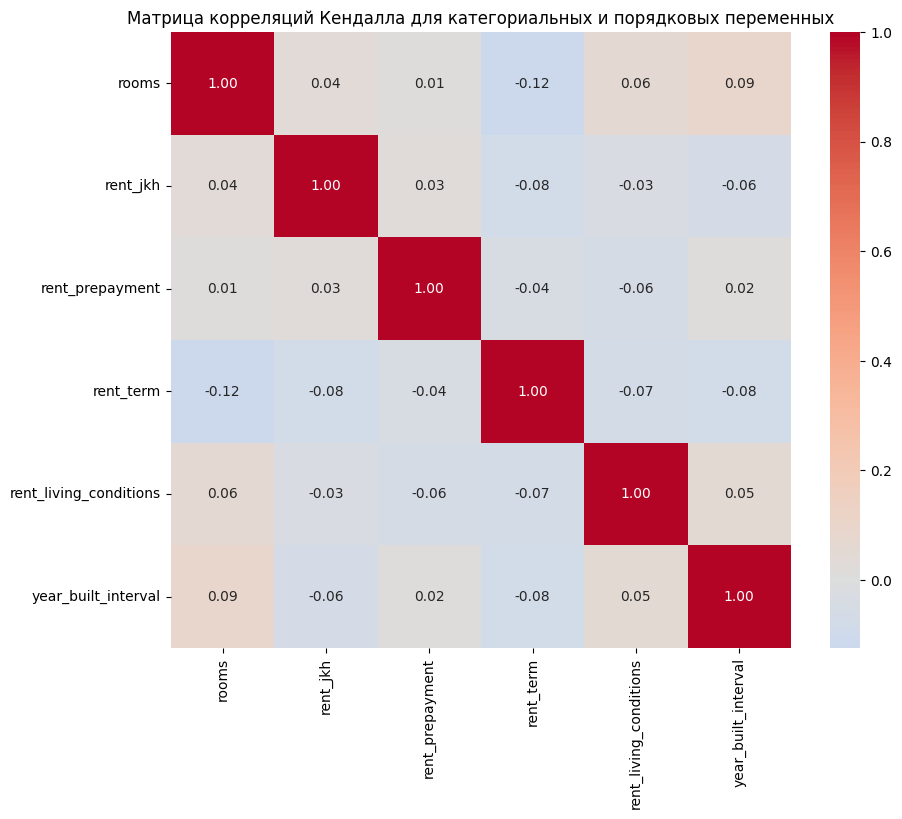

In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_ordinal_vars = [
    'rooms',
    'rent_jkh',
    'rent_prepayment',
    'rent_term',
    'rent_living_conditions',
    'year_built_interval'
]

# Сначала копируем данные
df_encoded = df_we[categorical_ordinal_vars].copy()

# Преобразуем все категории в числа
label_encoders = {}
for col in categorical_ordinal_vars:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le  # если потом понадобится обратно декодировать

# Считаем корреляцию Кендалла
kendall_corr = df_encoded.corr(method='kendall')

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Матрица корреляций Кендалла для категориальных и порядковых переменных')
plt.show()


In [ ]:
df_e.to_csv('final_encoded.csv', index=False)
print("Файл сохранён как final_encoded.csv")

Файл сохранён как final_encoded.csv
